In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
from scipy import ndimage as ndi
from scipy import stats
import matplotlib.pyplot as plt
import glob
import re
from tqdm import tqdm

from skimage import measure, morphology
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.segmentation import clear_border
from skimage.filters import roberts, sobel

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
DATA_PATH = '/kaggle_3/stage1_processed_unseg/'
DATA_PATH2 = '/kaggle_2/stage2_processed_unseg/'
PATIENT_SCANS = 'scan_lungs_'
DATA_PATH_SEGMENTED = '/kaggle/dev/data-science-bowl-2017-data/stage1_processed/'
PATIENT_SCANS_SEGMENTED_LUNGS = 'scan_segmented_lungs_'
PATIENT_SCANS_SEGMENTED_LUNGS_FILL = 'scan_segmented_lungs_fill_'

In [8]:
def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [4]:
patient_ids = []

for folder in glob.glob(DATA_PATH + PATIENT_SCANS + '*')[0:10]:
    m = re.match(PATIENT_SCANS +'([a-f0-9].*).npy', os.path.basename(folder))
    patient_uid = m.group(1)
    patient_ids.append(patient_uid)

# for folder in glob.glob(DATA_PATH2 + PATIENT_SCANS + '*')[0:10]:
#     m = re.match(PATIENT_SCANS +'([a-f0-9].*).npy', os.path.basename(folder))
#     patient_uid = m.group(1)
#     patient_ids.add(patient_uid)

In [5]:
patient_scans = []
for patient_id in patient_ids:
    print('patient_id (UNSEGMENTED)', patient_id)
    if os.path.isfile(DATA_PATH + PATIENT_SCANS + patient_id + '.npy'):
        scans = np.load(DATA_PATH + PATIENT_SCANS + patient_id + '.npy')
        patient_scans.append(scans)
    elif os.path.isfile(DATA_PATH2 + PATIENT_SCANS + patient_id + '.npy'):
        scans = np.load(DATA_PATH2 + PATIENT_SCANS + patient_id + '.npy')
        patient_scans.append(scans)
    else:
        with open("error.out", "a") as myfile:
            myfile.write('Couldnt find scan for patient {}'.format(patient_id))

patient_scans_segented_lungs = []
for patient_id in patient_ids:
    print('patient_id (SEGMENTED LUNGS)', patient_id)
    scans = np.load(DATA_PATH_SEGMENTED + PATIENT_SCANS_SEGMENTED_LUNGS + patient_id + '.npy')
    patient_scans_segented_lungs.append(scans)
    
patient_scans_segented_lungs_fill = []
for patient_id in patient_ids:
    print('patient_id (SEGMENTED LUNGS FILL)', patient_id)
    scans = np.load(DATA_PATH_SEGMENTED + PATIENT_SCANS_SEGMENTED_LUNGS_FILL + patient_id + '.npy')
    patient_scans_segented_lungs_fill.append(scans)


patient_id (UNSEGMENTED) 3295f3f392d8e130155c8912b60161b5
patient_id (UNSEGMENTED) c928b4fee44ea322ac65348ae2ff20b8
patient_id (UNSEGMENTED) a334d15ac8d2d25bce76693b1b2a3ed7
patient_id (UNSEGMENTED) 7395f64fba89c2463a1b13c400adf876
patient_id (UNSEGMENTED) 089b8f10743e449a0f64f8f311dd8a46
patient_id (UNSEGMENTED) fbae4d04285789dfa32124c86586dd09
patient_id (UNSEGMENTED) 1e0f8048728717064645cb758eb89279
patient_id (UNSEGMENTED) 7ec258e536a1e0353375295ad1b71e5b
patient_id (UNSEGMENTED) b82efe72526c59a96257208d95e54baf
patient_id (UNSEGMENTED) 4b2f615f5498ee9d935b0229a2e6bb19
patient_id (SEGMENTED LUNGS) 3295f3f392d8e130155c8912b60161b5
patient_id (SEGMENTED LUNGS) c928b4fee44ea322ac65348ae2ff20b8
patient_id (SEGMENTED LUNGS) a334d15ac8d2d25bce76693b1b2a3ed7
patient_id (SEGMENTED LUNGS) 7395f64fba89c2463a1b13c400adf876
patient_id (SEGMENTED LUNGS) 089b8f10743e449a0f64f8f311dd8a46
patient_id (SEGMENTED LUNGS) fbae4d04285789dfa32124c86586dd09
patient_id (SEGMENTED LUNGS) 1e0f804872871706464

patient_id: 3295f3f392d8e130155c8912b60161b5
------UN-SEGMENTED SCAN------


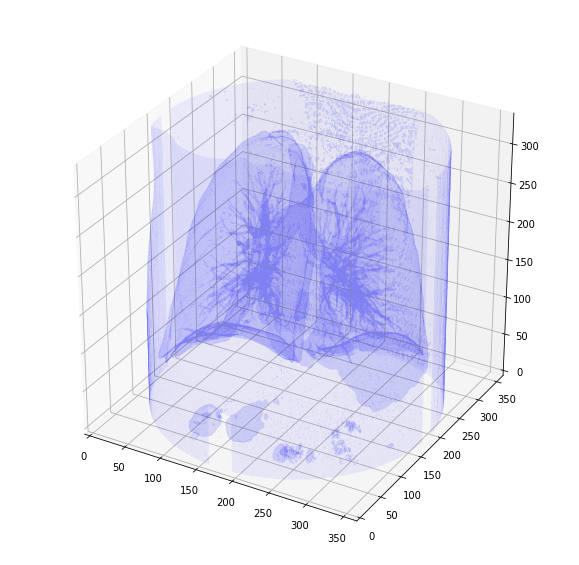

------SEGMENTED LUNGS------


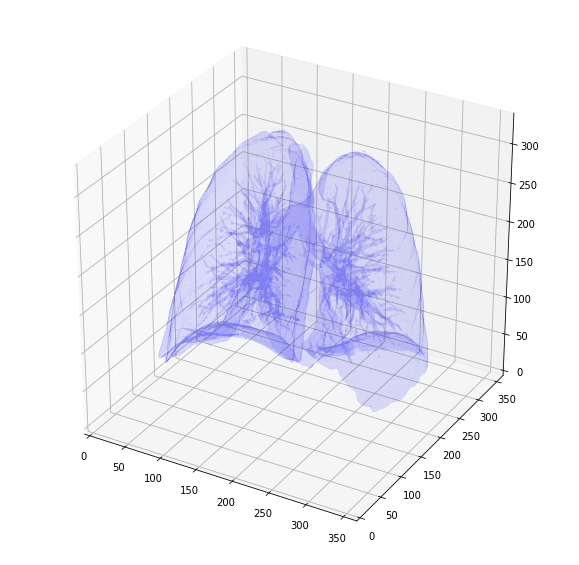

------SEGMENTED LUNGS FILL------


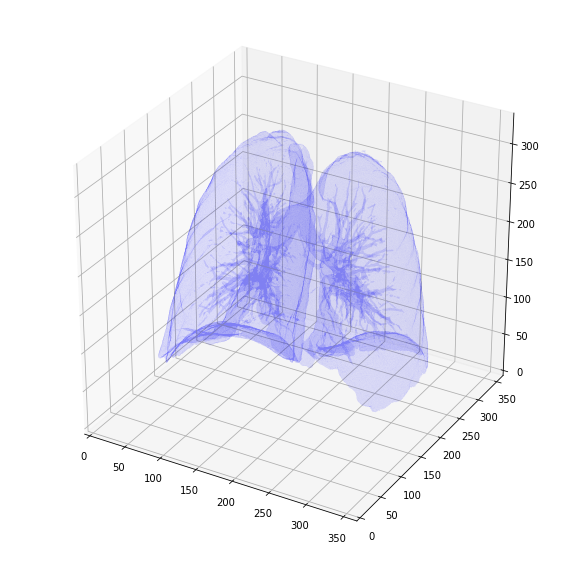

patient_id: c928b4fee44ea322ac65348ae2ff20b8
------UN-SEGMENTED SCAN------


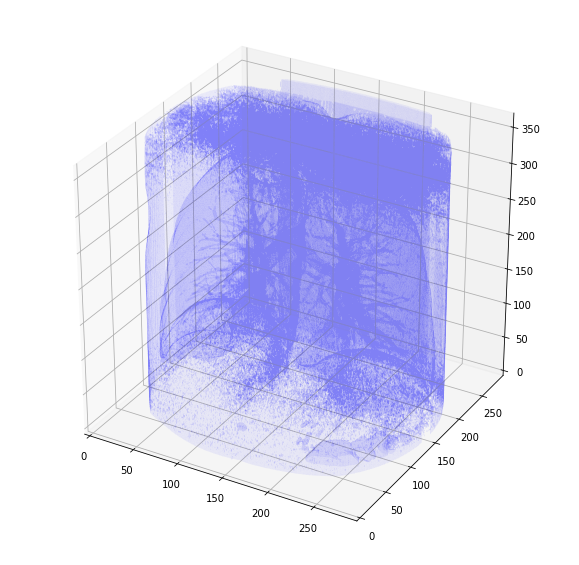

------SEGMENTED LUNGS------


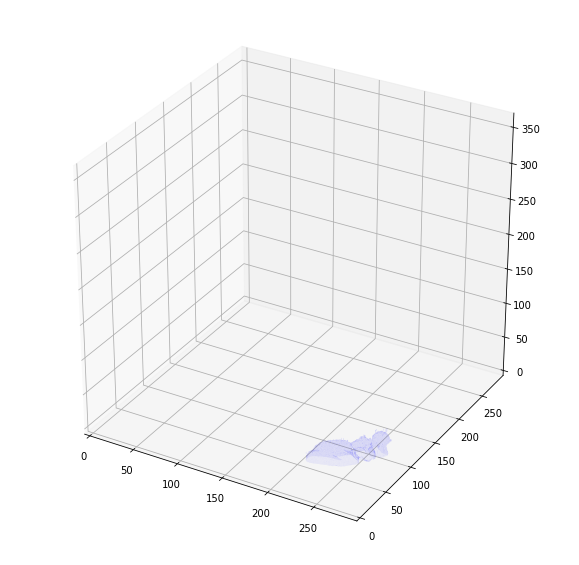

------SEGMENTED LUNGS FILL------


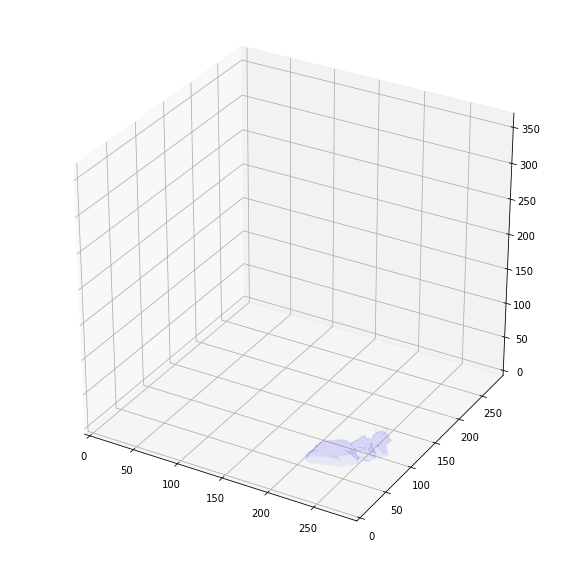

patient_id: a334d15ac8d2d25bce76693b1b2a3ed7
------UN-SEGMENTED SCAN------


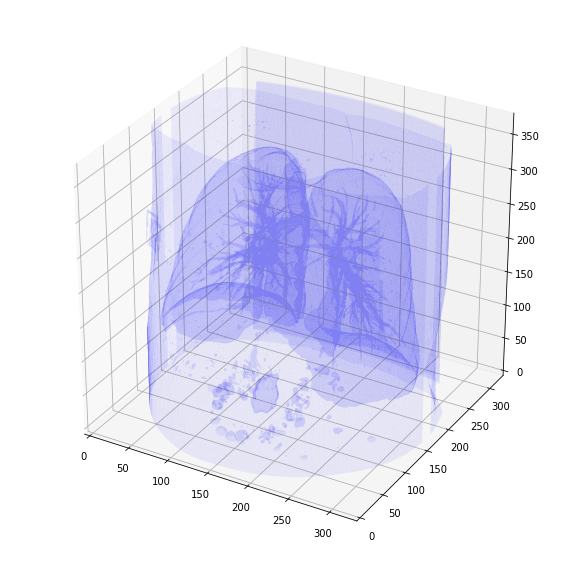

------SEGMENTED LUNGS------


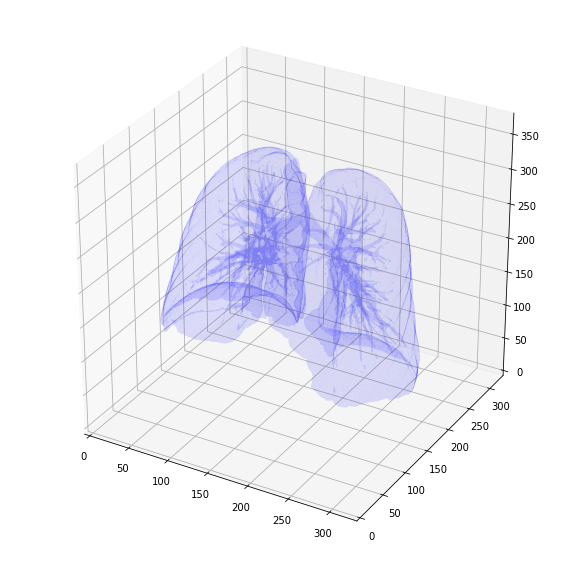

------SEGMENTED LUNGS FILL------


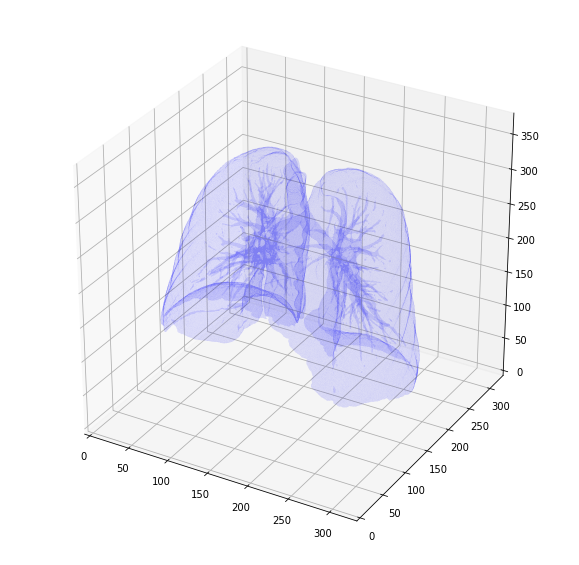

patient_id: 7395f64fba89c2463a1b13c400adf876
------UN-SEGMENTED SCAN------


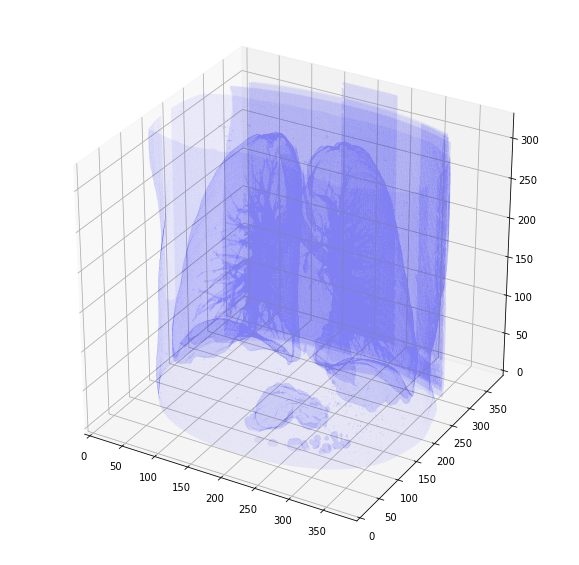

------SEGMENTED LUNGS------


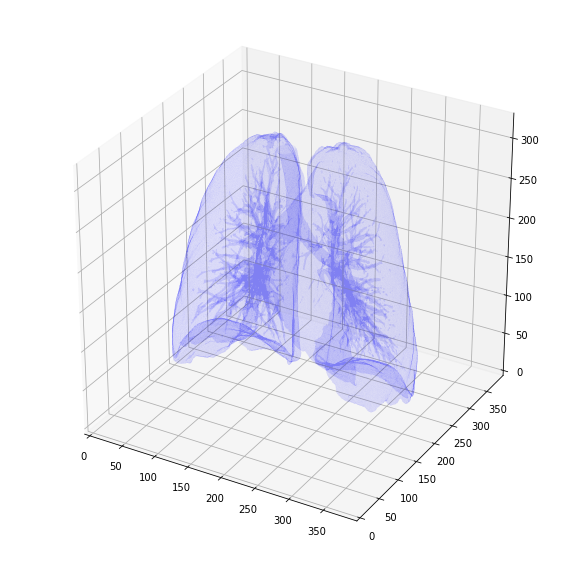

------SEGMENTED LUNGS FILL------


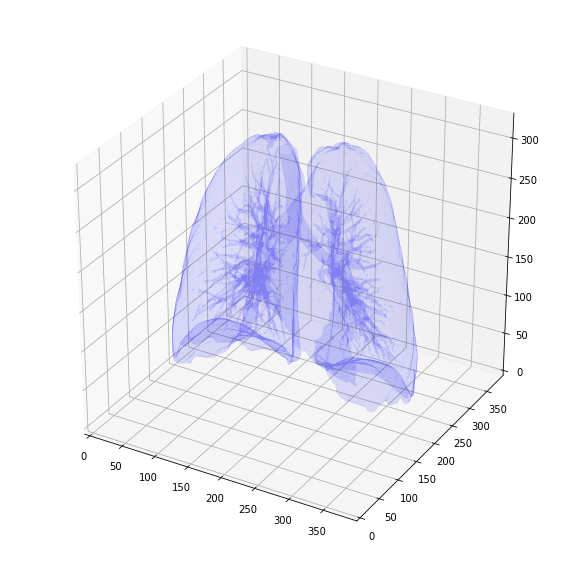

patient_id: 089b8f10743e449a0f64f8f311dd8a46
------UN-SEGMENTED SCAN------


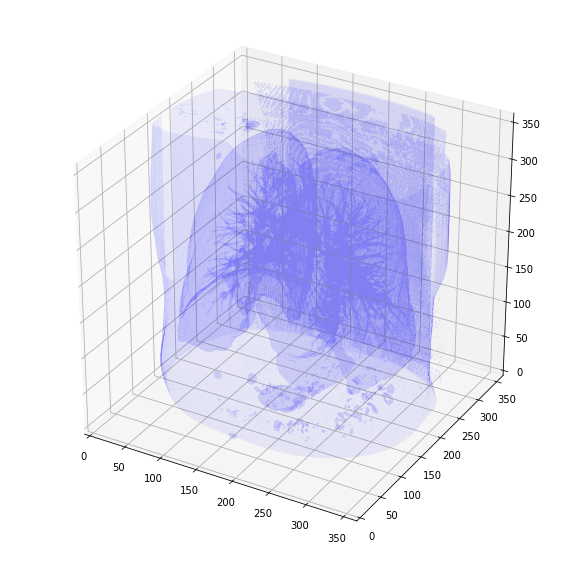

------SEGMENTED LUNGS------


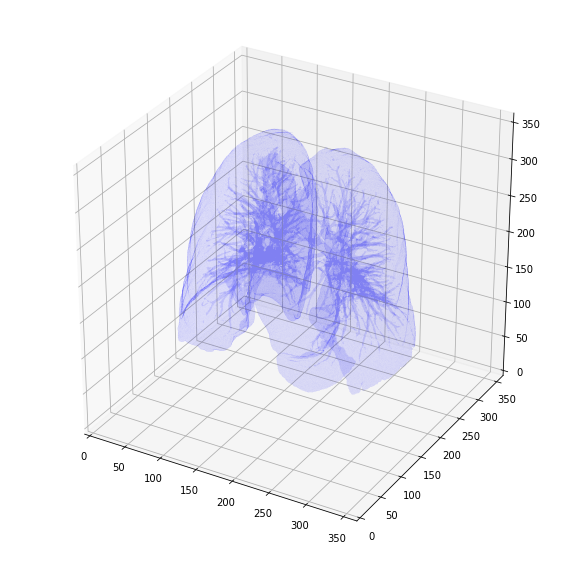

------SEGMENTED LUNGS FILL------


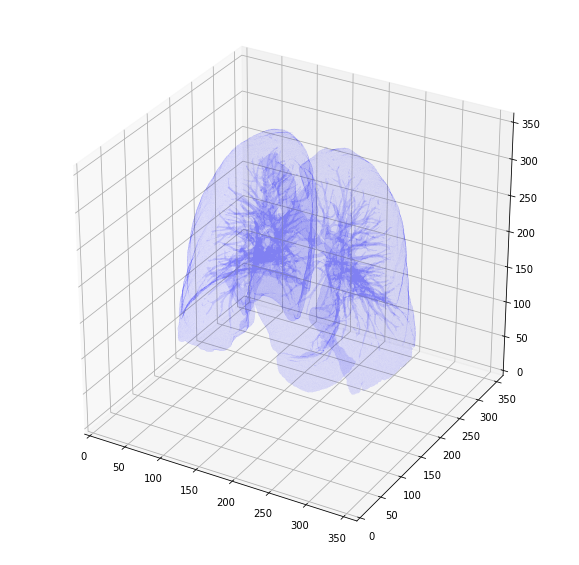

patient_id: fbae4d04285789dfa32124c86586dd09
------UN-SEGMENTED SCAN------


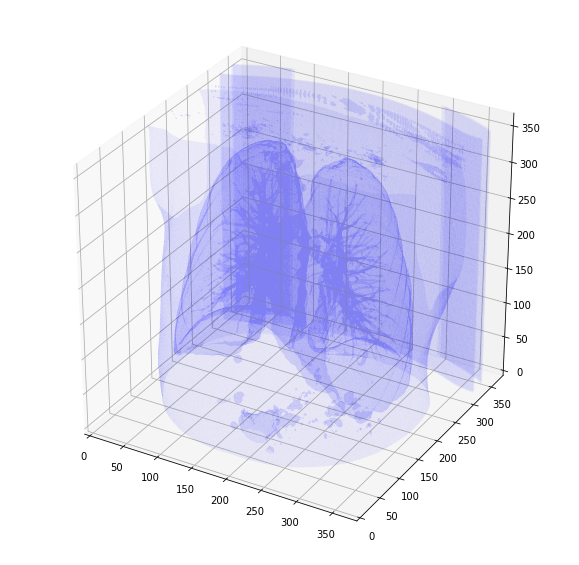

------SEGMENTED LUNGS------


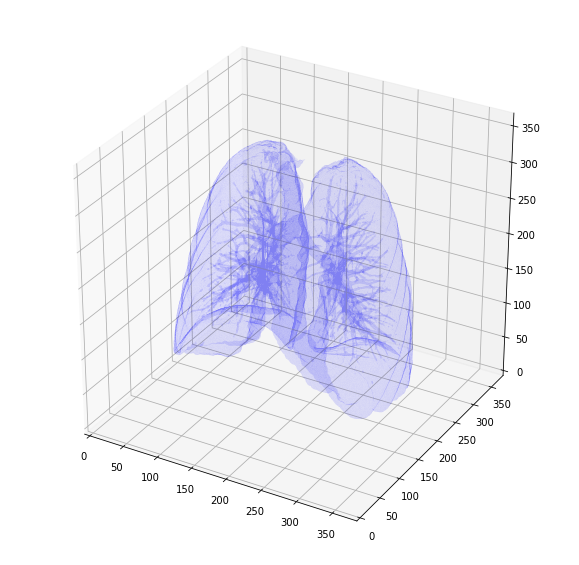

------SEGMENTED LUNGS FILL------


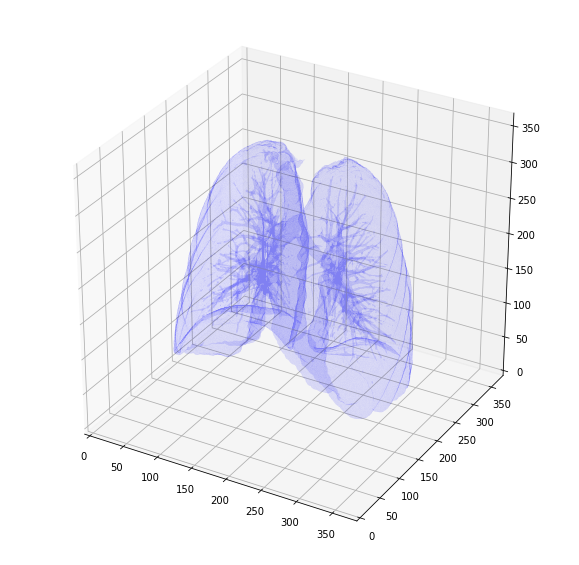

patient_id: 1e0f8048728717064645cb758eb89279
------UN-SEGMENTED SCAN------


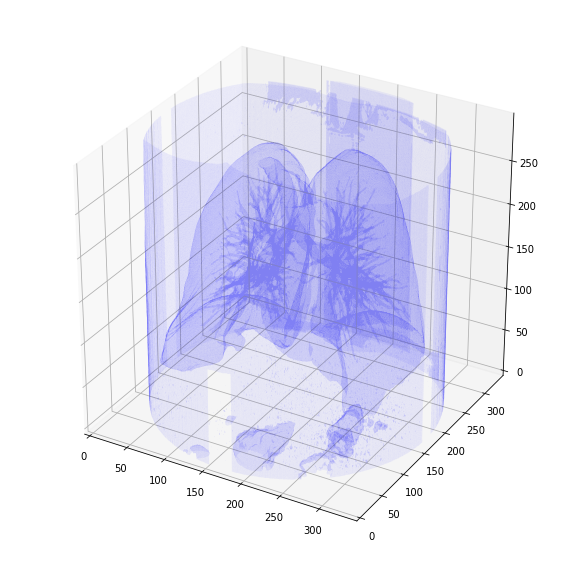

------SEGMENTED LUNGS------


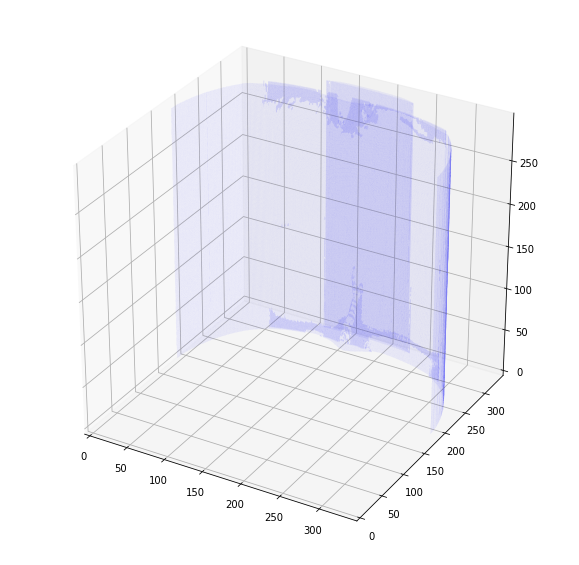

------SEGMENTED LUNGS FILL------


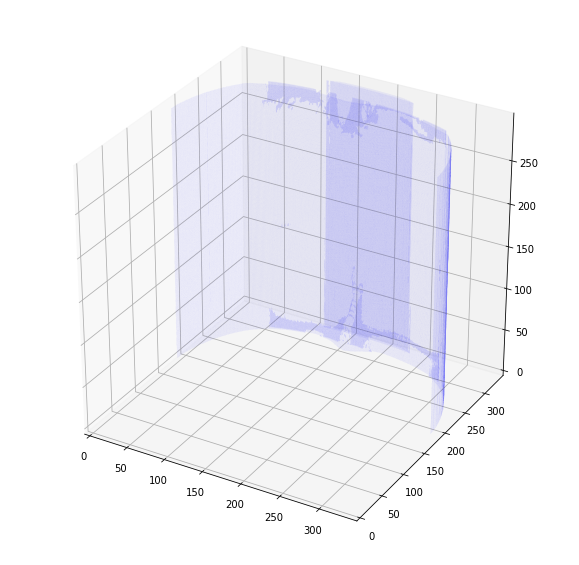

patient_id: 7ec258e536a1e0353375295ad1b71e5b
------UN-SEGMENTED SCAN------


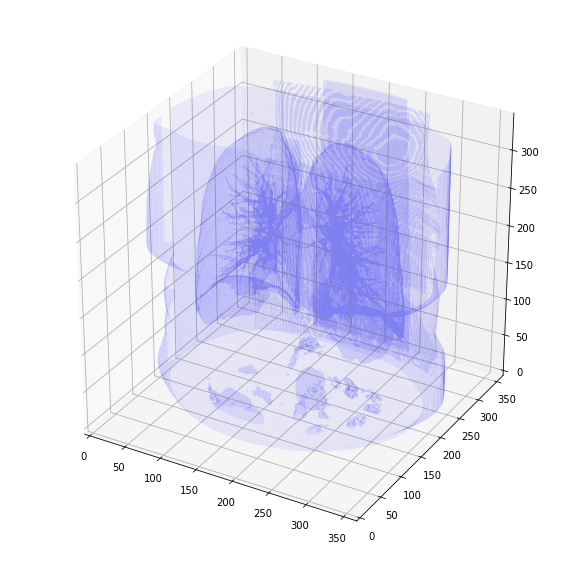

------SEGMENTED LUNGS------


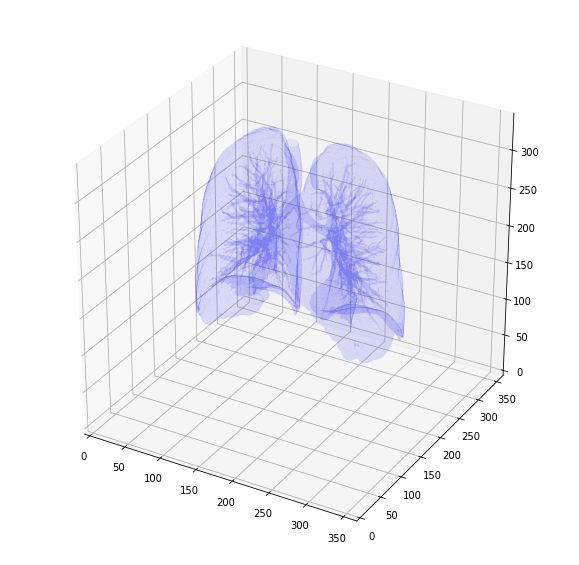

------SEGMENTED LUNGS FILL------


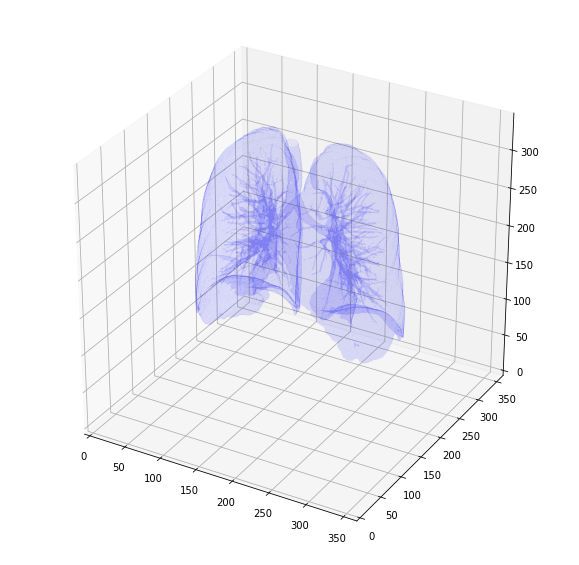

patient_id: b82efe72526c59a96257208d95e54baf
------UN-SEGMENTED SCAN------


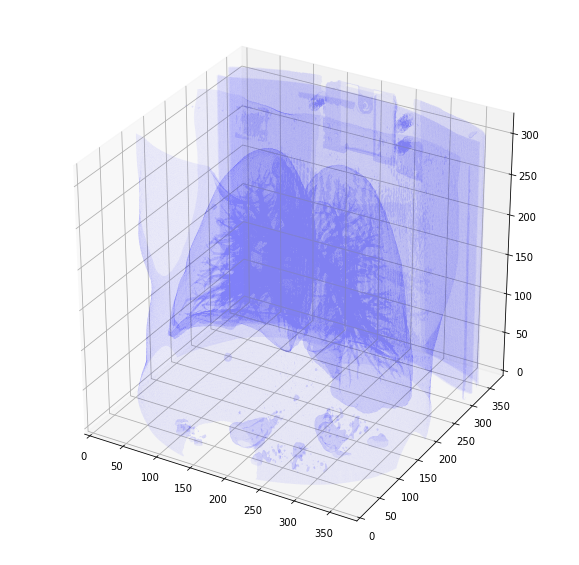

------SEGMENTED LUNGS------


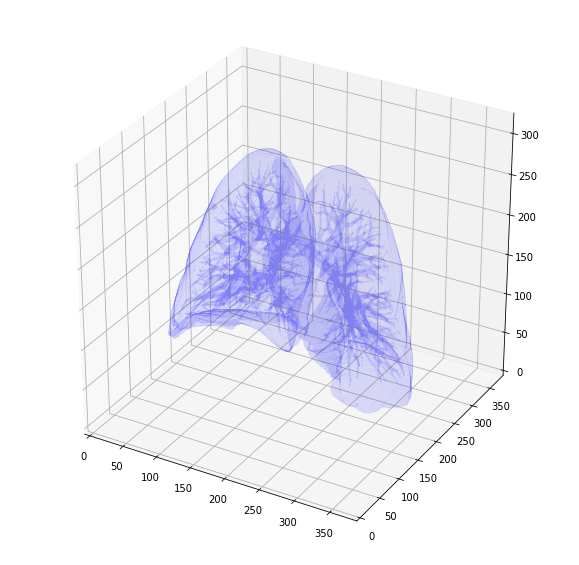

------SEGMENTED LUNGS FILL------


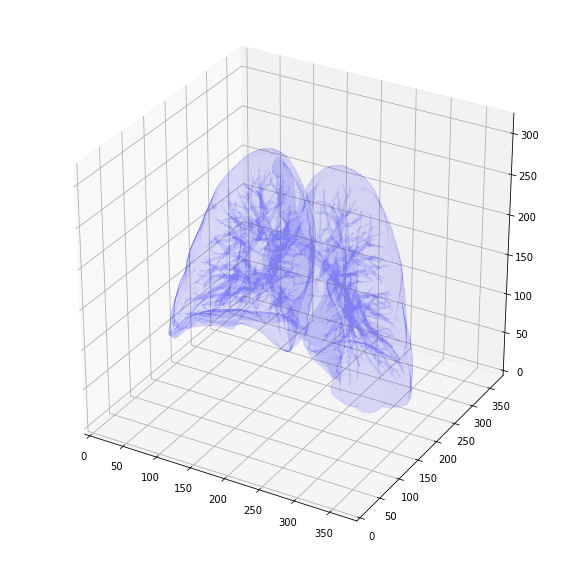

patient_id: 4b2f615f5498ee9d935b0229a2e6bb19
------UN-SEGMENTED SCAN------


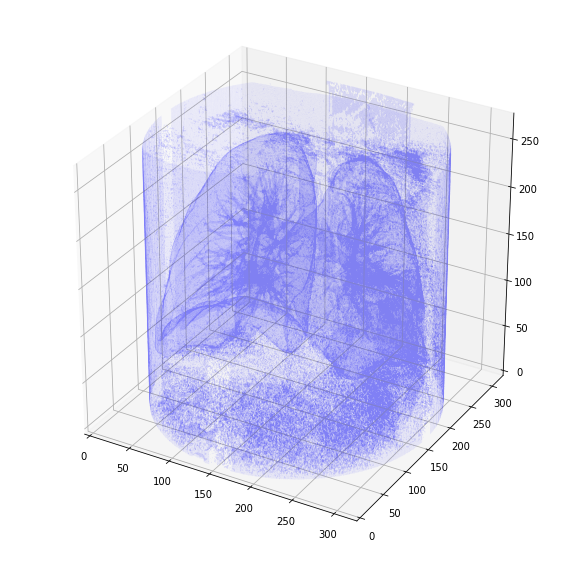

------SEGMENTED LUNGS------


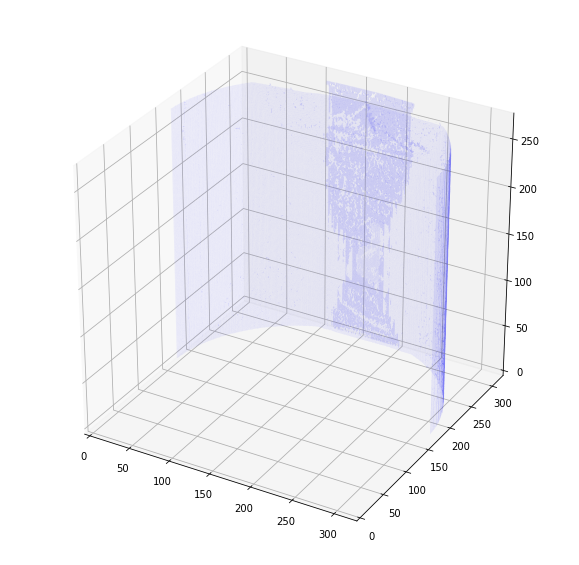

------SEGMENTED LUNGS FILL------


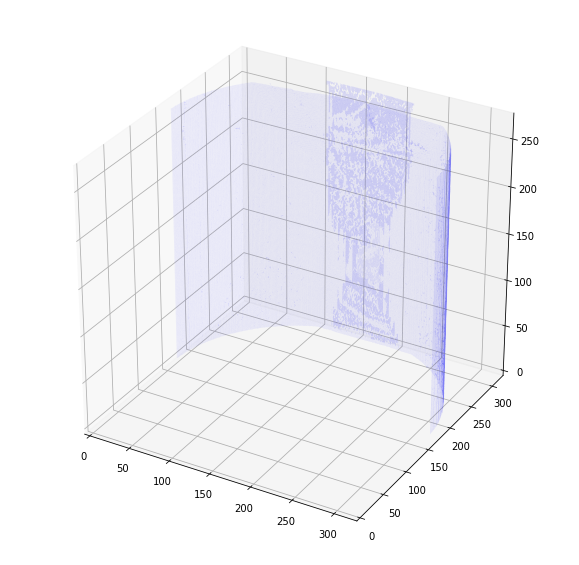

In [6]:
for i in range(len(patient_scans)):
    print('patient_id:', patient_ids[i])
    print('------UN-SEGMENTED SCAN------')
    plot_3d(patient_scans[i])
    print('------SEGMENTED LUNGS------')
    plot_3d(patient_scans_segented_lungs[i])
    print('------SEGMENTED LUNGS FILL------')
    plot_3d(patient_scans_segented_lungs_fill[i])

In [59]:
defective_patients = []
blank_cube_mean = -61

for i in tqdm(range(len(patient_scans))):
    # print('patient_id:', patient_ids[i])
    
    # print('- SEGMENTED LUNGS - ')
    scan_lung = patient_scans_segented_lungs[i]
    center_lung = np.full((48, 48, 48), -1000.0)
    center_0 = int(scan_lung.shape[0]/2)
    center_1 = int(scan_lung.shape[1]/2)
    center_2 = int(scan_lung.shape[2]/2)
    center_lung[0:-1, 0:-1, 0:-1] = scan_lung[center_0: center_0+47, center_1: center_1+47, center_2: center_2+47]
    # print(int(np.mean(center_lung)))
    center_lung_mean = int(np.mean(center_lung))
    #plot_3d(center_lung)
    
    # print('- SEGMENTED LUNGS FILL - ')
    scan_lung_fill = patient_scans_segented_lungs_fill[i]
    center_lung_fill = np.full((48, 48, 48), -1000.0)
    center_0 = int(scan_lung_fill.shape[0]/2)
    center_1 = int(scan_lung_fill.shape[1]/2)
    center_2 = int(scan_lung_fill.shape[2]/2)

    center_lung_fill[0:-1, 0:-1, 0:-1] = scan_lung_fill[center_0: center_0+47, center_1: center_1+47, center_2: center_2+47]
    # print(int(np.mean(center_lung_fill)))
    center_lung_fill_mean = int(np.mean(center_lung_fill))
    #plot_3d(center_lung_fill)
    
    if center_lung_mean == blank_cube_mean or center_lung_fill_mean == blank_cube_mean:
        defective_patients.append(patient_ids[i])    

100%|██████████| 10/10 [00:00<00:00, 1173.95it/s]


In [60]:
defective_patients

['c928b4fee44ea322ac65348ae2ff20b8',
 '1e0f8048728717064645cb758eb89279',
 '4b2f615f5498ee9d935b0229a2e6bb19']

## Running on the whole data set

In [ ]:
DATA_PATH = '/kaggle/dev/data-science-bowl-2017-data/stage1_processed/'
DATA_PATH2 = '/kaggle_3/stage2_processed/'
PATIENT_SCANS = 'scan_segmented_lungs_fill_'

STAGE2_SUBMISSION = '/kaggle/dev/data-science-bowl-2017-data/stage2_sample_submission.csv'

blank_cube_mean = -61


def identifying_defective_scans():

    patient_ids = set()
    defective_patients = set()
    
    for folder in glob.glob(DATA_PATH + PATIENT_SCANS + '*'):
        m = re.match(PATIENT_SCANS +'([a-f0-9].*).npy', os.path.basename(folder))
        patient_uid = m.group(1)
        patient_ids.add(patient_uid)

    for folder in glob.glob(DATA_PATH2 + PATIENT_SCANS + '*'):
        m = re.match(PATIENT_SCANS +'([a-f0-9].*).npy', os.path.basename(folder))
        patient_uid = m.group(1)
        patient_ids.add(patient_uid)
        
    sample_submission = pd.read_csv(STAGE2_SUBMISSION)
    test_patient_ids = set(sample_submission['id'].tolist())
        
    for patient_id in tqdm(patient_ids):
        if os.path.isfile(DATA_PATH + PATIENT_SCANS + patient_id + '.npy'):
            scans = np.load(DATA_PATH + PATIENT_SCANS + patient_id + '.npy')
        elif os.path.isfile(DATA_PATH2 + PATIENT_SCANS + patient_id + '.npy'):
            scans = np.load(DATA_PATH2 + PATIENT_SCANS + patient_id + '.npy')
        else:
            with open("error.out", "a") as myfile:
                myfile.write('Couldnt find scan for patient {}'.format(patient_id))
    
        
        center_lung_fill = np.full((48, 48, 48), -1000.0)
        center_0 = int(scans.shape[0]/2)
        center_1 = int(scans.shape[1]/2)
        center_2 = int(scans.shape[2]/2)

        center_lung_fill[0:-1, 0:-1, 0:-1] = scans[center_0: center_0+47, center_1: center_1+47, center_2: center_2+47]
        center_lung_fill_mean = int(np.mean(center_lung_fill))
        
        if center_lung_fill_mean == blank_cube_mean:
            if test_patient_ids in test_patient_ids:
                print('DANGER:', patient_id, 'is a defective scan and also in the test set')
            defective_patients.add(patient_id) 
        del center_lung_fill, scans  
        
    del patient_ids    
    return defective_patients
    
defective_patients = identifying_defective_scans()

print('defective patient ids:')
defective_patients

 23%|██▎       | 486/2101 [13:07<1:04:16,  2.39s/it]